## Unit 03 Lesson 03
####Why : Do Welthier countries provide better education?
####Where : https://courses.thinkful.com/data-001v2/lesson/3.3

In [8]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

# URL with data
url = "http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm"

# Getting data from the web and storing for soup analysis
r = requests.get(url)
soup = BeautifulSoup(r.content)


In [9]:
data = []
# I only consider the 7th table 
table = soup.findAll('table')[6]
# I take only the 2nd table within the table where I have data I want
table = table.findAll('table')[1]

rows = table.findAll('tr')
for row in rows:
    # Iterate over column. This scripte take account for blank space too
    cols = row.find_all('td')
    # This allow me to remove all the tag between <>
    cols = [ele.text.rstrip() for ele in cols]
    data.append([ele for ele in cols]) 

# drop first 6 row
data = data[5::]
# I obtain a list of of list with 12 elements each, blank spaces 
# included.

# Dataframe creation
col = ['country','year','','','total','','','men','','','women','']
school_df = pd.DataFrame(data,columns=col)
# Drop blank column
school_df.drop('', axis=1, inplace=True)
# Transform string to int
school_df.year = school_df['year'].apply(int)
school_df.total = school_df['total'].apply(int)
school_df.men = school_df['men'].apply(int)
school_df.women = school_df['women'].apply(int)
school_df = school_df.set_index('country')

## Create a gdp dataframe for years 1999 to 2010
Starting from world bank .csv data, extract data for GDP for each country, in year range 1999 to 2010 in order to compare the GDP value with the school expectancy.

In [33]:
# Why : Compare GDP to Educational Attainment
# Where : https://courses.thinkful.com/data-001v2/project/3.3.4

# Read the csv data (skip the first 2 rows)
gdp_df_row = pd.read_csv('world bank data/ny.gdp.mktp.cd_Indicator_en_csv_v2.csv',skiprows=2)
# Make a first dataframe for only Country name to indicator name column
gdp_df1 = gdp_df_row.ix[:, 'Country Name']
# Make a first dataframe for only years 1999 to 2010 (as the school life expectancy dataframe (school_df))
gdp_df2 = gdp_df_row.ix[:, '1999':'2010']
#  concatenate the two dataframe to create a unique dataframe
gdp_df = pd.concat([gdp_df1, gdp_df2], axis=1)
# rename the column 'Country Name' in 'country' to match the school_df
gdp_df = gdp_df.rename(columns = {'Country Name':'country'})


Now gdp_df is a dataframe with following columns: country | 1999 | 2000 | ... | 2010 , where for each year we have a GDP value. I need to reshape the dataframe in order to have 3 columns: Country | Year | GDP to make analysis with the schhol_df.

In [ ]:
# reshape the dataframe (using stack fonction) in order to have 3 columns (Year | GDP | Country)
id = gdp_df.ix[:, ['country']]
gdp_df = pd.merge(gdp_df.stack(0).reset_index(1), id, left_index=True, right_index=True)
gdp_df.columns = ['year','GDP','country']
# delete first line of each country
gdp_df = gdp_df[gdp_df.year != 'country']

gdp_df = gdp_df.set_index('country')
# Transform string to int
gdp_df.year = gdp_df['year'].apply(int)
gdp_df.GDP = gdp_df['GDP'].apply(int

 ## Using SQLite to store data and create the new table for analysis 
 ####Why : Storing the data
 
 ####Where : https://courses.thinkful.com/data-001v2/assignment/3.3.3

In [12]:
# Why : Storing the data
# Where : https://courses.thinkful.com/data-001v2/assignment/3.3.3

# I do have a dataframe already, I do not need a sql table creation.
# men = school_df.men.describe()
# women = school_df.women.describe()

# print(school_df.describe())

import sqlite3

# create and connect to a database
conn = sqlite3.connect('education.db')

# All interactions with the database are called querys
# And they require to be used through a cursor
c = conn.cursor()
# The queries are applied using the .execute() method
c.execute('DROP TABLE IF EXISTS school')
c.execute('DROP TABLE IF EXISTS gdp')
# Create a new table called school from pandas dataframe
school_df.to_sql('school', conn)
# Create a new table called gdp from pandas dataframe
gdp_df.to_sql('gdp', conn)

# Retrieve data merged in SQLITE (school table merged in SQLite with gdp table in order to keep only the GDP value 
# corresponding to the year of school expectancy)

merged_df = pd.read_sql_query('''SELECT school.country, gdp.year, gdp.GDP, total, men, women 
                FROM gdp 
                INNER JOIN school 
                ON gdp.year=school.year AND gdp.country=school.country;''',conn)

####### Comment LP ########
# I do not really have idea to how adjust automaticlly the countries that do not match.

 ## Plotting and analysis 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a753f90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f5b17d0>]], dtype=object)

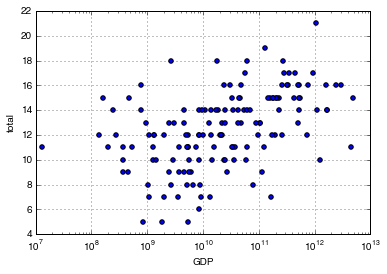

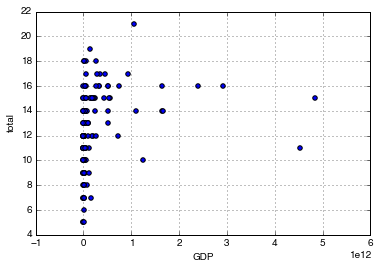

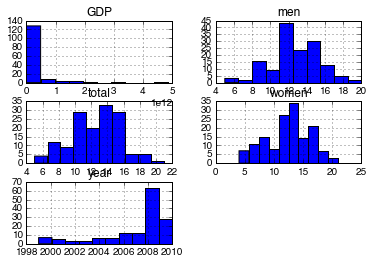

In [29]:
# Plotting scatterplot with and without logarithmic x axes as weel histograms of all variables to analyzing distributions

merged_df.plot(x='GDP',y='total',kind='scatter',logx=True)
merged_df.plot(x='GDP',y='total',kind='scatter')
merged_df.hist()

In [26]:
# Doing some analysis, fit a model
# Ordinary Least Squares = Linear Regression
import statsmodels.formula.api as smf

model = smf.ols(formula="total ~ GDP", data=merged_df)
fitted_model = model.fit()
corr = fitted_model.rsquared_adj
print fitted_model.summary()
print "The correlation between GDP and expectancy is only  of {0:.2f}".format(corr)


                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     8.318
Date:                Wed, 29 Jul 2015   Prob (F-statistic):            0.00452
Time:                        09:34:42   Log-Likelihood:                -369.43
No. Observations:                 147   AIC:                             742.9
Df Residuals:                     145   BIC:                             748.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.2090      0.264     46.254      0.0